In [1]:
import os
import argparse
from utils import util
from models.cut_seg import CUT_SEG_model
import torch
from utils.create_dataset import PairedEczemaDataset, UnpairedEczemaDataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

/home/vw/anaconda3/envs/i2i/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h1> plot the loss curve </h1></br>
<h4> plot netG loss </h4>

In [35]:
loss_path = 'output/victor_dataset/wag_vic_lossG/loss/loss_300'

In [36]:
loss = []
with (open(loss_path, "rb")) as openfile:
    while True:
        try:
            loss.append(pickle.load(openfile))
        except EOFError:
            break
loss = loss[0]

In [37]:
print(len(loss))

300


In [38]:
loss_G = [l['G'] for l in loss]
# loss_GAN = [l['G_GAN'] for l in loss]
loss_D_real = [l['D_real'] for l in loss]
loss_D_fake = [l['D_fake'] for l in loss]

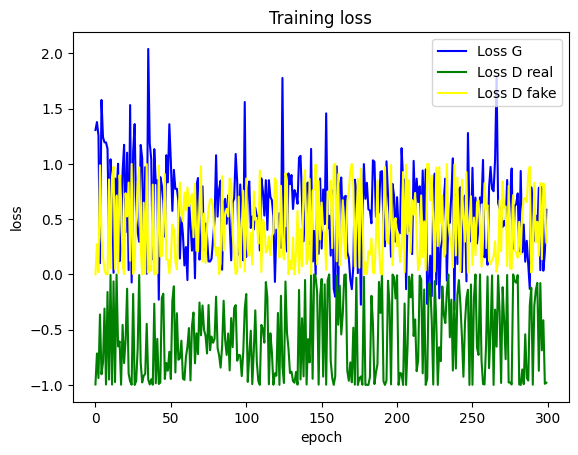

In [39]:
plt.plot(loss_G, color='blue', label='Loss G')
# plt.plot(loss_GAN, color='purple', label='Loss GAN')
plt.plot(loss_D_real, color='green', label='Loss D real')
plt.plot(loss_D_fake, color='yellow', label='Loss D fake')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
ax = plt.gca()
# ax.set_ylim([0, 2.0])
plt.title('Training loss')
plt.savefig('evaluation/victor_dataset/wag/vic_lossG/loss')
plt.show()

<h1>Load the network</h1>

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else: device = torch.device('cpu')

device

device(type='cuda')

In [23]:
def ArgParse():
    parser = argparse.ArgumentParser(description='For model training')
    # basic parameters
    parser.add_argument('--model', type=str, default='ag_cut', help='chooses which model to use.', choices=['cut_seg', 'cyclegan', 'dcl', 'distance', 'kx_cut', 'ag_cut', 'ag_cycle'])
    parser.add_argument('--train_src_dir', help='Train-source dataset folder', type=str, default='datasets/victor_dataset/white/train')
    parser.add_argument('--train_tar_dir', help='Train-target dataset folder', type=str, default='datasets/victor_dataset/non_white/train')
    parser.add_argument('--test_src_dir', help='Test-source dataset folder', type=str, default='datasets/victor_dataset/white/test')
    parser.add_argument('--test_tar_dir', help='Test-target dataset folder', type=str, default='datasets/victor_dataset/non_white/test')
    parser.add_argument('--batchSize', type=int, default=1, help='input batch size')
    parser.add_argument('--name', type=str, default='config_1' ,help='name of the experiment. It decides where to store samples and models')
    parser.add_argument('--easy_label', type=str, default='config_1', help='Interpretable name')
    parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints', help='models are saved here')
    parser.add_argument('--load', help='if to load the network', action='store_true')
    parser.add_argument('--load_path', help='where to load the network')
    parser.add_argument('--load_epoch', help='which checkpoint to load', type=int, default=5)
    # the output dir is set for demo
    parser.add_argument('--out_dir', help='Outputs folder', type=str, default='evaluation/victor_dataset/ag')
    
    """GAN parameters"""
    parser.add_argument('--input_nc', type=int, default=3, help='# of input image channels: 3 for RGB and 1 for grayscale')
    parser.add_argument('--output_nc', type=int, default=4, help='# of output image channels: 3 for RGB and 1 for grayscale')
    parser.add_argument('--ngf', type=int, default=64, help='# of gen filters in the last conv layer')
    parser.add_argument('--ndf', type=int, default=64, help='# of discrim filters in the first conv layer')
    parser.add_argument('--netD', type=str, default='ag', choices=['basic', 'n_layers', 'ag', 'probag'], help='specify discriminator architecture. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator')
    parser.add_argument('--netG', type=str, default='ag', choices=['resnet_9blocks', 'resnet_6blocks', 'ag', 'probag'], help='specify generator architecture')
    parser.add_argument('--n_layers_D', type=int, default=3, help='only used if netD==n_layers')
    parser.add_argument('--normG', type=str, default='batch', choices=['instance', 'batch', 'none'], help='instance normalization or batch normalization for G')
    parser.add_argument('--normD', type=str, default='batch', choices=['instance', 'batch', 'none'], help='instance normalization or batch normalization for D')
    parser.add_argument('--init_type', type=str, default='normal', choices=['normal', 'xavier', 'kaiming', 'orthogonal'], help='network initialization')
    parser.add_argument('--init_gain', type=float, default=0.02, help='scaling factor for normal, xavier and orthogonal.')
    parser.add_argument('--no_dropout', type=util.str2bool, nargs='?', const=True, default=True,
                        help='no dropout for the generator')
    parser.add_argument('--antialias', action='store_true',default=False ,help='if specified, use antialiased-downsampling')
    parser.add_argument('--antialias_up', action='store_true',default=False ,help='if specified, use [upconv(learned filter)]')
    
    """netS parameters"""
    parser.add_argument('--netS_lambda', type=int, default=10, help='lambda for SEG loss')
    parser.add_argument('--netS_Loss', type=str, help='semantic segmentation loss function', choices=['dice', 'bce', 'DICE', 'BCE'], default='dice')
    parser.add_argument('--netS', type=str, default='smp', choices=['resnet', 'unet_256', 'smp'], help='how to segment the input image')
    parser.add_argument('--smp_arch', type=str, default='Unet', help='the segmentor architectur')
    parser.add_argument('--smp_encoder', type=str, default='efficientnet-b3', help='the encoder name')
    parser.add_argument('--normS', type=str, default='instance', choices=['instance', 'batch', 'none'], help='instance normalization or batch normalization for S')
    parser.add_argument('--num_class', type=int, default=2, help='# of output image channels for segmented mask')

    # training parameters
    parser.add_argument('--n_epochs', type=int, default=200, help='number of epochs with the initial learning rate')
    parser.add_argument('--n_epochs_decay', type=int, default=200, help='number of epochs to linearly decay learning rate to zero')
    parser.add_argument('--beta1', type=float, default=0.5, help='momentum term of adam')
    parser.add_argument('--beta2', type=float, default=0.999, help='momentum term of adam')
    parser.add_argument('--lr', type=float, default=0.0001, help='initial learning rate for adam')
    parser.add_argument('--lr_policy', type=str, default='linear', help='learning rate policy. [linear | step | plateau | cosine]')
    parser.add_argument('--lr_decay_iters', type=int, default=50, help='multiply by a gamma every lr_decay_iters iterations')
    parser.add_argument('--cycliclr', action='store_true', help='to use cyclic learning rate')
    parser.add_argument('--base_lr', type=float, default=0.00001, help='base lr for cyclic')
    parser.add_argument('--isTrain', type=util.str2bool, default=True, help='select to train the model')
    parser.add_argument('--strongG', action='store_true', default=True, help='stronger loss G')
    
    # network saving and loading parameters
    parser.add_argument('--save_epoch_freq', type=int, default=5, help='frequency of saving checkpoints at the end of epochs')
    parser.add_argument('--evaluation_freq', type=int, default=5000, help='evaluation freq')
    parser.add_argument('--save_by_iter', action='store_true', help='whether saves model by iteration')
    parser.add_argument('--epoch_count', type=int, default=1, help='the starting epoch count, we save the model by <epoch_count>, <epoch_count>+<save_latest_freq>, ...')
    parser.add_argument('--phase', type=str, default='train', help='train, val, test, etc')
    parser.add_argument('--pretrained_name', type=str, default=None, help='resume training from another checkpoint')

    """cyclegan parameters"""
    parser.add_argument('--lambda_A', type=float, default=10.0, help='weight for cycle loss (A -> B -> A)')
    parser.add_argument('--lambda_B', type=float, default=10.0, help='weight for cycle loss (B -> A -> B)')
    parser.add_argument('--lambda_identity', type=float, default=0, help='use identity mapping. Setting lambda_identity other than 0 has an effect of scaling the weight of the identity mapping loss.\
                        For example, if the weight of the identity loss should be 10 times smaller than the weight of the reconstruction loss, please set lambda_identity = 0.1')
    parser.add_argument('--pool_size', type=int, default=100, help='the size of image pool')

    """cut parameters"""
    parser.add_argument('--CUT_mode', type=str, default="cut", choices=['CUT', 'cut', 'FastCUT', 'fastcut'], help='')
    parser.add_argument('--lambda_GAN', type=float, default=1.0, help='weight for GAN loss：GAN(G(X))')
    
    
    """netF paramters"""
    parser.add_argument('--lambda_NCE', type=float, default=1.0, help='weight for NCE loss: NCE(G(X), X)')
    parser.add_argument('--nce_idt', type=util.str2bool, nargs='?', const=True, default=True, help='use NCE loss for identity mapping: NCE(G(Y), Y))')
    parser.add_argument('--nce_layers', type=str, default='0,3,5,7,11', help='compute NCE loss on which layers')
    parser.add_argument('--netF', type=str, default='mlp_sample', choices=['sample', 'reshape', 'mlp_sample'], help='how to downsample the feature map')
    parser.add_argument('--netF_nc', type=int, default=256)
    parser.add_argument('--nce_T', type=float, default=0.07, help='temperature for NCE loss')
    parser.add_argument('--num_patches', type=int, default=256, help='number of patches per layer')
    parser.add_argument('--flip_equivariance',
                    type=bool, nargs='?', default=False,
                    help="Enforce flip-equivariance as additional regularization. It's used by FastCUT, but not CUT")
    
    """dcl paramters"""
    parser.add_argument('--DCL_mode', type=str, default="DCL", choices='DCL')
    
    """distance parameters"""
    parser.add_argument('--lambda_distance_A', type=float, default=1.0, help='weight for distance loss (A -> B)')
    parser.add_argument('--lambda_distance_B', type=float, default=1.0, help='weight for distance loss (B -> A)')

    """attention gan parameters"""
    parser.add_argument('--lambda_pixel', type=float, default=1)
    parser.add_argument('--lambda_reg', type=float, default=1e-6)
    parser.add_argument('--lambda_content', type=float, default=1e-6)

    parser.add_argument('--gan_curriculum', type=int, default=10, help='Strong GAN loss for certain period at the beginning')
    parser.add_argument('--starting_rate', type=float, default=0.01, help='Set the lambda weight between GAN loss and Recon loss during curriculum period at the beginning. We used the 0.01 weight.')
    parser.add_argument('--default_rate', type=float, default=0.5, help='Set the lambda weight between GAN loss and Recon loss after curriculum period. We used the 0.5 weight.')
    
    opt, _ = parser.parse_known_args()

    # Set default parameters for CUT and FastCUT
    if opt.CUT_mode.lower() == "cut" and (opt.model.lower() == 'cut_seg' or opt.model.lower() == 'kx_cut'):
        parser.set_defaults(nce_idt=True, lambda_NCE=1.0)
        parser.set_defaults(pool_size=0)  # no image pooling

    elif opt.CUT_mode.lower() == "fastcut" and (opt.model.lower() == 'cut_seg' or opt.model.lower() == 'kx_cut'):
        parser.set_defaults(
            nce_idt=False, lambda_NCE=10.0, flip_equivariance=True,
            n_epochs=150, n_epochs_decay=50
        )
        parser.set_defaults(pool_size=0)  # no image pooling

    elif opt.model.lower() == 'cyclegan':
        parser.set_defaults(
            lambda_identity=0.5, pool_size = 100
        )
    elif opt.model.lower() == 'dcl' and opt.DCL_mode.lower() == 'dcl':
         parser.set_defaults(
            nce_idt=True, lambda_identity=1.0, 
            lambda_NCE = 2.0, nce_layers = '4,8,12,16'
        )
         parser.set_defaults(pool_size=0)  # no image pooling
    elif opt.model.lower() == 'distance':
        parser.set_defaults(
            lambda_identity=0.5, pool_size = 100, batchSize=2
        )
    elif opt.model.lower() == 'ag_cycle':
        parser.set_defaults(
            lambda_identity=0, lambda_cycle=10,
            netD='ag', netG='ag', pool_size=50,
            output_nc=4
        )
    elif opt.CUT_mode.lower() == "cut" and opt.model.lower() == 'ag_cut':
        parser.set_defaults(
            lambda_identity=0, lambda_NCE=1.0,
            netD='ag', netG='ag', pool_size=0,
            output_nc=4, nce_idt=True
        )
    elif opt.CUT_mode.lower() == "fastcut" and opt.model.lower() == 'ag_cut':
        parser.set_defaults(
            lambda_identity=0, lambda_NCE=10.0,
            netD='ag', netG='ag', pool_size=0,
            output_nc=4, nce_idt=False,flip_equivariance=True,
            n_epochs=150, n_epochs_decay=50
        )
    else:
        raise ValueError(opt.CUT_mode)

    return opt


Namespace(model='ag_cut', train_src_dir='datasets/datasets_paired/train/pairedA', train_tar_dir='datasets/datasets_paired/train/pairedB', test_src_dir='datasets/datasets_paired/test/pairedA', test_tar_dir='datasets/datasets_paired/test/pairedB', batchSize=1, name='ag_fast', easy_label='ag_fast', checkpoints_dir='./checkpoints', load=False, load_path=None, load_seg_path=None, load_seg_epoch=495, load_epoch=5, out_dir='ag_fast', input_nc=3, output_nc=4, ngf=64, ndf=64, netD='ag', netG='ag', n_layers_D=3, normG='instance', normD='instance', init_type='xavier', init_gain=0.02, no_dropout=True, antialias=False, antialias_up=False, netS_lambda=10, netS_Loss='bce', netS='resnet', smp_arch='Unet', smp_encoder='efficientnet-b3', normS='instance', num_class=2, n_epochs=150, n_epochs_decay=200, beta1=0.5, beta2=0.999, lr=0.0002, lr_policy='linear', lr_decay_iters=50, isTrain=True, save_epoch_freq=1, evaluation_freq=5000, save_by_iter=False, epoch_count=1, phase='train', pretrained_name=None, lambda_A=10.0, lambda_B=10.0, lambda_identity=0, pool_size=0, CUT_mode='fastcut', lambda_GAN=1.0, lambda_NCE=10.0, nce_idt=False, nce_layers='0,3,5,7,11', netF='mlp_sample', netF_nc=256, nce_T=0.07, num_patches=256, flip_equivariance=True, DCL_mode='DCL', lambda_distance_A=1.0, lambda_distance_B=1.0, lambda_pixel=1, lambda_reg=1e-06, gan_curriculum=10, starting_rate=0.01, default_rate=0.5, n_epochs_delay=50)


In [24]:
opt = ArgParse()
opt

Namespace(model='ag_cut', train_src_dir='datasets/victor_dataset/white/train', train_tar_dir='datasets/victor_dataset/non_white/train', test_src_dir='datasets/victor_dataset/white/test', test_tar_dir='datasets/victor_dataset/non_white/test', batchSize=1, name='config_1', easy_label='config_1', checkpoints_dir='./checkpoints', load=False, load_path=None, load_seg_path=None, load_seg_epoch=495, load_epoch=5, out_dir='evaluation/victor_dataset/ag', input_nc=3, output_nc=4, ngf=64, ndf=64, netD='ag', netG='ag', n_layers_D=3, normG='batch', normD='batch', init_type='normal', init_gain=0.02, no_dropout=True, antialias=False, antialias_up=False, netS_lambda=10, netS_Loss='dice', netS='smp', smp_arch='Unet', smp_encoder='efficientnet-b3', normS='instance', num_class=2, n_epochs=200, n_epochs_decay=200, beta1=0.5, beta2=0.999, lr=0.0001, lr_policy='linear', lr_decay_iters=50, cycliclr=False, base_lr=1e-05, isTrain=True, strongG=True, save_epoch_freq=5, evaluation_freq=5000, save_by_iter=False, 

<h2> load kx_cut </h2>  

In [ ]:
from models.kx_cut_seg import KX_CUT
kx_cut = KX_CUT(opt=opt)

In [ ]:
kx_cut_netG = getattr(kx_cut, 'netG')
if isinstance(kx_cut_netG, torch.nn.DataParallel):
    kx_cut_netG = kx_cut_netG.module

In [ ]:
# load
load_path = 'checkpoints/kx_cut/300_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
kx_cut_netG.load_state_dict(state_dict)

<h2> load config_1 </h2>  

In [ ]:
from models.cut_seg import CUT_SEG_model
config_1 = CUT_SEG_model(opt)

In [ ]:
config_1_netG = getattr(config_1, 'netG')
if isinstance(config_1_netG, torch.nn.DataParallel):
    config_1_netG = config_1_netG.module

In [ ]:
# load
load_path = 'checkpoints/config_1/300_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
config_1_netG.load_state_dict(state_dict)

<h2>load config_2 </h2>

In [ ]:
from models.kx_cut_seg import KX_CUT
config_2 = KX_CUT(opt=opt)

In [ ]:
config_2_netG = getattr(config_2, 'netG')
if isinstance(config_2_netG, torch.nn.DataParallel):
    config_2_netG = config_2_netG.module

In [ ]:
# load
load_path = 'checkpoints/config_2/300_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
config_2_netG.load_state_dict(state_dict)

<h2> load config_3 </h2>

In [ ]:
from models.cut_seg import CUT_SEG_model
config_3 = CUT_SEG_model(opt)

In [ ]:
config_3_netG = getattr(config_3, 'netG')
if isinstance(config_3_netG, torch.nn.DataParallel):
    config_3_netG = config_3_netG.module

In [ ]:
# load
load_path = 'checkpoints/config_3/300_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
config_3_netG.load_state_dict(state_dict)

<h2> load config_4 </h2>

In [ ]:
from models.kx_cut_seg import KX_CUT
config_4 = KX_CUT(opt=opt)

In [ ]:
config_4_netG = getattr(config_4, 'netG')
if isinstance(config_4_netG, torch.nn.DataParallel):
    config_4_netG = config_4_netG.module

In [ ]:
# load
load_path = 'checkpoints/config_4/300_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
config_4_netG.load_state_dict(state_dict)

<h2> load config_5 </h2> 

In [ ]:
from models.cut_seg import CUT_SEG_model
config_5 = CUT_SEG_model(opt)

In [ ]:
config_5_netG = getattr(config_5, 'netG')
if isinstance(config_5_netG, torch.nn.DataParallel):
    config_5_netG = config_5_netG.module

In [ ]:
# load
load_path = 'checkpoints/config_5/300_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
config_5_netG.load_state_dict(state_dict)

<h2> load kx_cut_dice </h2>

In [ ]:
from models.kx_cut_seg import KX_CUT
kx_cut_dice = KX_CUT(opt=opt)

In [ ]:
kx_cut_dice_netG = getattr(kx_cut_dice, 'netG')
if isinstance(kx_cut_dice_netG, torch.nn.DataParallel):
    kx_cut_dice_netG = kx_cut_dice_netG.module

In [ ]:
# load
load_path = 'checkpoints/kx_cut_dice/200_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
kx_cut_dice_netG.load_state_dict(state_dict)

<h2> load config_2 dice </h2>

In [ ]:
from models.kx_cut_seg import KX_CUT
config_2_dice = KX_CUT(opt=opt)

In [ ]:
config_2_dice_netG = getattr(config_2_dice, 'netG')
if isinstance(config_2_dice_netG, torch.nn.DataParallel):
    config_2_dice_netG = config_2_dice_netG.module

In [ ]:
# load
load_path = 'checkpoints/config_2_dice/200_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
config_2_dice_netG.load_state_dict(state_dict)

<h2> load config_4 dice</h2>

In [ ]:
from models.kx_cut_seg import KX_CUT
config_4_dice = KX_CUT(opt=opt)

In [ ]:
config_4_dice_netG = getattr(config_4_dice, 'netG')
if isinstance(config_4_dice_netG, torch.nn.DataParallel):
    config_4_dice_netG = config_4_dice_netG.module

In [ ]:
# load
load_path = 'checkpoints/config_4_dice/200_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
config_4_dice_netG.load_state_dict(state_dict)

<h2>load fast_cut</h2>

In [ ]:
from models.kx_cut_seg import KX_CUT
fast_cut = KX_CUT(opt=opt)

In [ ]:
fast_cut_netG = getattr(fast_cut, 'netG')
if isinstance(fast_cut_netG, torch.nn.DataParallel):
    fast_cut_netG = fast_cut_netG.module

In [ ]:
# load
load_path = 'checkpoints/fast_cut_bce/200_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
fast_cut_netG.load_state_dict(state_dict)

<h2>load dcl</h2>

In [ ]:
from models.dcl_model import DCLModel
dcl = DCLModel(opt=opt)

In [ ]:
dcl_netG_A = getattr(dcl, 'netG_A')
if isinstance(dcl_netG_A, torch.nn.DataParallel):
    dcl_netG_A = dcl_netG_A.module

In [ ]:
# load
load_path = 'checkpoints/dcl_bce/200_net_G_A.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
dcl_netG_A.load_state_dict(state_dict)

<h2>load cyclegan</h2>

In [ ]:
from models.cycleGAN import CycleGAN
cyc = CycleGAN(opt=opt)

In [ ]:
cyc_netG_A = getattr(cyc, 'netG_A')
if isinstance(cyc_netG_A, torch.nn.DataParallel):
    cyc_netG_A = cyc_netG_A.module

In [ ]:
# load
load_path = 'checkpoints/cyc_bce/200_net_G_A.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
cyc_netG_A.load_state_dict(state_dict)

<h2>load distance</h2>

In [ ]:
from models.distance_model import DistanceGAN
dist = DistanceGAN(opt=opt)

In [ ]:
dist_netG_A = getattr(dist, 'netG_A')
if isinstance(dist_netG_A, torch.nn.DataParallel):
    dist_netG_A = dist_netG_A.module

In [ ]:
# load
load_path = 'checkpoints/dis_bce/195_net_G_A.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
dist_netG_A.load_state_dict(state_dict)

<h2>load ag_cut</h2>

In [25]:
from models.ag_cut import AG_Cut
ag_cut = AG_Cut(opt=opt)

In [26]:
ag_cut_netG = getattr(ag_cut, 'netG')
if isinstance(ag_cut_netG, torch.nn.DataParallel):
    ag_cut_netG = ag_cut_netG.module

In [27]:
# load
load_path = 'checkpoints/victor_dataset/ag_vic_lr1e-6_pix2/300_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
ag_cut_netG.load_state_dict(state_dict)

<All keys matched successfully>

<h2>load wagcut

In [5]:
from models.ag_cut import AG_Cut
wag_cut = AG_Cut(opt=opt)

In [6]:
wag_cut_netG = getattr(wag_cut, 'netG')
if isinstance(wag_cut_netG, torch.nn.DataParallel):
    wag_cut_netG = wag_cut_netG.module

In [7]:
# load
load_path = 'checkpoints/victor_dataset/wag_vic_lossG/300_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
wag_cut_netG.load_state_dict(state_dict)

<All keys matched successfully>

<h2>load ag_fast_cut</h2>

In [ ]:
from models.ag_cut import AG_Cut
ag_fast_cut = AG_Cut(opt=opt)

In [ ]:
ag_fast_cut_netG = getattr(ag_fast_cut, 'netG')
if isinstance(ag_fast_cut_netG, torch.nn.DataParallel):
    ag_fast_cut_netG = ag_fast_cut_netG.module

In [ ]:
# load
load_path = 'checkpoints/ag_cut_newloss/200_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
ag_fast_cut_netG.load_state_dict(state_dict)

<h2>load ag_cycle</h2>

In [ ]:
from models.ag_cycle import AG_Cycle
ag_cyc = AG_Cycle(opt=opt)

In [ ]:
ag_cyc_netG_A = getattr(ag_cyc, 'netG_A')
if isinstance(ag_cyc_netG_A, torch.nn.DataParallel):
    ag_cyc_netG_A = ag_cyc_netG_A.module

In [ ]:
# load
load_path = 'checkpoints/ag_cycle/300_net_G_A.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
ag_cyc_netG_A.load_state_dict(state_dict)

<h2>load cut_seg

In [ ]:
from models.cut_seg import CUT_SEG_model
cut_seg = CUT_SEG_model(opt)

In [ ]:
cut_seg_netG = getattr(cut_seg, 'netG')
if isinstance(cut_seg_netG, torch.nn.DataParallel):
    cut_seg_netG = cut_seg_netG.module

In [ ]:
# load
load_path = 'checkpoints/cut_seg_lr/300_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
cut_seg_netG.load_state_dict(state_dict)

In [ ]:
cut_seg_netS = getattr(cut_seg, 'netS')
if isinstance(cut_seg_netS, torch.nn.DataParallel):
    cut_seg_netS = cut_seg_netS.module

In [ ]:
# load
load_path = 'checkpoints/cut_seg_lr/300_net_S.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
cut_seg_netS.load_state_dict(state_dict)

<h1>load fast cut seg</h1>

In [ ]:
from models.cut_seg import CUT_SEG_model
fast_cut_seg = CUT_SEG_model(opt)

In [ ]:
fast_cut_seg_netG = getattr(fast_cut_seg, 'netG')
if isinstance(fast_cut_seg_netG, torch.nn.DataParallel):
    fast_cut_seg_netG = fast_cut_seg_netG.module

In [ ]:
# load
load_path = 'checkpoints/fast_cut_seg/300_net_G.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
fast_cut_seg_netG.load_state_dict(state_dict)

In [ ]:
fast_cut_seg_netS = getattr(cut_seg, 'netS')
if isinstance(fast_cut_seg_netS, torch.nn.DataParallel):
    fast_cut_seg_netS = fast_cut_seg_netS.module

In [ ]:
# load
load_path = 'checkpoints/fast_cut_seg/300_net_S.pth'
state_dict = torch.load(load_path, map_location=str(device))
if hasattr(state_dict, '_metadata'):
    del state_dict._metadata
fast_cut_seg_netS.load_state_dict(state_dict)

<h1>generate the EczemaDataset</h1>

In [9]:
from PIL import UnidentifiedImageError
import torch.utils.data as data
import os
from glob import glob
import numpy as np
from torch.autograd import Variable
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from utils.util import img2tensor
import random


class UnpairedEczemaDataset(data.Dataset):
    def __init__(self, src_img_path):
        super().__init__()
        
        self.src_img_path = []
        for ext in ('*.jpg', '*.png', '*.JPG', '*.PNG'):
            self.src_img_path.extend(glob(os.path.join(src_img_path, ext)))

        
    def __len__(self):
        return len(self.src_img_path)
    
    
    def transform(self, real_img):
        # Resize
        resize = T.Resize(size=(256,256), interpolation=T.InterpolationMode.NEAREST)
        real_img = resize(real_img)

        return real_img
    
    def normalize(self, real_img):
        normalize_real_img = real_img.squeeze(0)
        normalize_real_img = (normalize_real_img - 127.5) / 127.5
        
        return normalize_real_img
        
    
    def __getitem__(self, index):
        try:
            real_img = np.asarray(Image.open(self.src_img_path[index]))
        except UnidentifiedImageError as e:
            real_img =  np.asarray(Image.open(self.src_img_path[np.random.randint(0,len(self.src_img_path))]))
           
        real_img = img2tensor(real_img)
        # transform the imgs
        t_real_img = self.transform(real_img)

        # normalize the imgs
        n_real_img = self.normalize(t_real_img)
        
        return n_real_img

In [10]:
print(opt.test_src_dir)
print(opt.test_tar_dir)

datasets/victor_dataset/white/test
datasets/victor_dataset/non_white/test


In [11]:
test_src = UnpairedEczemaDataset(opt.test_src_dir)
test_tar = UnpairedEczemaDataset(opt.test_tar_dir)

In [12]:
test_src_dataloader = DataLoader(test_src, batch_size=1, shuffle=False)
test_tar_dataloader = DataLoader(test_tar, batch_size=1, shuffle=False)

<h1> generate the translated image and save </h1>

In [ ]:
def generate_image(dataloader, netG, opt, device, name, mode='translated'):
    save_path = os.path.join(opt.out_dir, name)

    for idx, data in enumerate(dataloader):
        data = data.to(device)
        # translated
        translated = netG(data)
        translated = util.tensor2img(translated)
        translated = (translated * 127.5 + 127.5).astype(np.uint8)

        if mode == 'translated':
            plt.figure(figsize=(20, 20))
            plt.imshow(translated)
            plt.axis('off')
            plt.savefig(f'{save_path}/infer={idx + 1}.png')
            plt.close()
        
        elif mode == 'compare':
            # source
            source_img = util.tensor2img(data)
            source_img = (source_img * 127.5 + 127.5).astype(np.uint8)

            _, ax = plt.subplots(1, 2, figsize=(20, 20))
            ax[0].imshow(source_img)
            ax[1].imshow(translated)
            ax[0].set_title("Input")
            ax[1].set_title("Translated")
            ax[0].axis("off")
            ax[1].axis("off")

            plt.savefig(f'{save_path}/infer={idx + 1}.png')
            plt.close()            

In [18]:
def ag_generate_image(dataloader, netG, opt, device, name, translated_only=False):
    
    save_path = os.path.join(opt.out_dir, name)

    for idx, raw_data in enumerate(dataloader):

        # mask, data = raw_data[0], raw_data[1]
        data = raw_data
        data = data.to(device)
        # mask = mask.to(device)
        source_img = util.tensor2img(data)
        source_img = (source_img * 127.5 + 127.5).astype(np.uint8)
        # translated
        translated, translated_mask, translated_content = netG(data)
        translated = util.tensor2img(translated)
        translated = (translated * 127.5 + 127.5).astype(np.uint8)

        if translated_only:
            # plt.figure(figsize=(20, 20))
            # plt.imshow(translated)
            # plt.axis('off')
            # plt.savefig(f'{save_path}/infer={idx + 1}.png')
            # plt.close()
            plt.imsave(f'{save_path}/infer={idx + 1}.png', translated)
        else:
            titles = ['Source', "Translated", "Attention mask", "Content Mask"]
            _, ax = plt.subplots(1, len(titles), figsize=(20, 20))
            [ax[i].set_title(title) for i, title in enumerate(titles)]
            translated_mask = util.tensor2img(translated_mask, isMask=True)

            translated_content = util.tensor2img(translated_content)
            translated_content = (translated_content * 127.5 + 127.5).astype(np.uint8)

            [ax[j].imshow(img) for j, img in enumerate([source_img, translated, translated_mask, translated_content])]
            [ax[j].axis("off") for j in range(len(titles))]

            plt.savefig(f'{save_path}/infer={idx + 1}.png')
            plt.close()

In [ ]:
from torch.nn.functional import softmax

def seg_generate_image(dataloader, netG, netS, opt, device, name, mode='translated'):
    save_path = os.path.join(opt.out_dir, name)

    for idx, raw_data in enumerate(dataloader):
        titles = ['Source', "Translated", "Mask", "Pr mask",]
        _, ax = plt.subplots(1, len(titles), figsize=(20, 20))
        [ax[i].set_title(title) for i, title in enumerate(titles)]
        mask, data = raw_data[0], raw_data[1]
        data = data.to(device)
        mask = mask.to(device)
        source_img = util.tensor2img(data)
        source_img = (source_img * 127.5 + 127.5).astype(np.uint8)
        # predict the mask
        pr_mask = netS(data)
        pr_mask = softmax(pr_mask, dim=-1)
        pr_mask = pr_mask[0]
        content_mask_A = np.zeros([pr_mask.shape[1], pr_mask.shape[2]])
        for r in range(pr_mask.shape[1]):
            for c in range(pr_mask.shape[2]):
                if pr_mask[0][r][c] < pr_mask[1][r][c]:
                    content_mask_A[r][c] = 1
        pr_mask = content_mask_A
        content_mask_A = Variable(torch.from_numpy(content_mask_A.astype(np.float32)))
        content_mask_A = content_mask_A.unsqueeze(0).unsqueeze(0)
        # get content mask
        content_mask_A = content_mask_A.repeat(1,3,1,1)
        content_mask_A = content_mask_A.to(device)
        # get the content from image
        content_A = data*content_mask_A
        # generator translate content_A
        fake_B_content = netG(content_A)
        # global picture
        background_A = data*(1-content_mask_A)
        fake_B_global = fake_B_content + background_A
        # cast tensor to img
        # real_content = util.tensor2img(content_A)
        # translated_content = util.tensor2img(fake_B_content)
        # real_background = util.tensor2img(background_A)
        translated = util.tensor2img(fake_B_global)

        # normalize
        # real_content = (real_content * 127.5 + 127.5).astype(np.uint8)
        # translated_content = (translated_content * 127.5 + 127.5).astype(np.uint8)
        # real_background = (real_background * 127.5 + 127.5).astype(np.uint8)
        translated = (translated * 127.5 + 127.5).astype(np.uint8)

        mask = util.tensor2img(mask, isMask=True)

        [ax[j].imshow(img) for j, img in enumerate([source_img, translated, mask, pr_mask])]
        [ax[j].axis("off") for j in range(len(titles))]

        plt.savefig(f'{save_path}/infer={idx + 1}.png')
        plt.close()

<h1>Generate img for normal model

In [ ]:
name = 'fast_cut_bce/trans'

In [ ]:
netG = fast_cut_netG

In [ ]:
# generate translated images
generate_image(src_dataloader, netG=netG, opt=opt, device=device, name = name, mode='translated')

In [ ]:
original = [source[0], source[9], source[19], source[29], source[39], source[49], source[59], source[69], source[79], source[89]]

In [ ]:

save_path = os.path.join(opt.out_dir, 'original')

for idx, data in enumerate(original):
    data = data.to(device)
    data = util.tensor2img(data)
    data = (data * 127.5 + 127.5).astype(np.uint8)
    plt.figure(figsize=(20, 20))
    plt.imshow(data)
    plt.axis('off')
    plt.savefig(f'{save_path}/original={idx + 1}.png')
    plt.close()   

<h1>Generate img for AG model

In [28]:
name = 'ag_vic_lr1e-6_pix2/translated'

In [29]:
ag_netG = ag_cut_netG

In [30]:
# generate translated images
ag_generate_image(test_src_dataloader, netG=ag_netG, opt=opt, device=device, name = name, translated_only=True)

<h1>Generate img for SEG model</h1>

In [ ]:
name = 'cut_seg_lr'

In [ ]:
seg_netG = cut_seg_netG
seg_netS = cut_seg_netS

In [ ]:
seg_generate_image(test_src_dataloader, seg_netG, seg_netS, opt=opt, device=device, name = name, mode='translated')

<h1> Generate img for WAG model

In [19]:
print(opt.out_dir)

evaluation/victor_dataset/wag


In [20]:
name = 'vic_lossG/translated'

In [21]:
wag_netG = wag_cut_netG

In [22]:
# generate translated images
ag_generate_image(test_src_dataloader, netG=wag_netG, opt=opt, device=device, name = name, translated_only=True)

<h1>Save dataloader images</h1>

In [13]:
for idx, raw_data in enumerate(test_src_dataloader):
    # mask, data = raw_data[0], raw_data[1]
    data = raw_data
    data = data.to(device)
    # mask = mask.to(device)
    source_img = util.tensor2img(data)
    source_img = (source_img * 127.5 + 127.5).astype(np.uint8)
    plt.figure(figsize=(20, 20))
    plt.imshow(source_img)
    plt.axis('off')
    plt.savefig(f'evaluation/victor_dataset/test_tar/infer={idx + 1}.png')
    plt.close()

<h1>Compress non-white test</h1>

In [15]:
import os
from glob import glob

src_img_path = 'datasets/victor_dataset/non_white/test'
all_img = []
for ext in ('*.jpg', '*.png', '*.JPG', '*.PNG'):
    all_img.extend(glob(os.path.join(src_img_path, ext)))

In [16]:
import torchvision.transforms as T
import torchvision.transforms.functional as TF

def transform(real_img):
    # Resize
    resize = T.Resize(size=(286,286), interpolation=T.InterpolationMode.NEAREST)
    real_img = resize(real_img)

    # Random crop
    i, j, h, w = T.RandomCrop.get_params(
        real_img, output_size=(256, 256))
    real_img = TF.crop(real_img, i, j, h, w)

    return real_img

def normalize(real_img):
    normalize_real_img = real_img.squeeze(0)
    normalize_real_img = (normalize_real_img - 127.5) / 127.5
    
    return normalize_real_img

In [17]:
import numpy as np
from PIL import Image
from utils.util import img2tensor, tensor2img
import matplotlib.pyplot as plt 

for img in all_img:
    arr_img = np.asarray(Image.open(img))[:,:,:3]
    tensor = img2tensor(arr_img)
    t_img = transform(tensor)
    n_img = normalize(t_img)
    real_img = tensor2img(n_img)
    real_img = (real_img * 127.5 + 127.5).astype(np.uint8)

    save_path = 'evaluation/victor_dataset/non_white_transformed256x256'
    img = img.split('/')[-1]
    plt.imsave(os.path.join(save_path, img), real_img)

<h1>Calculate IS</h1>

In [1]:
from pytorch_gan_metrics import get_inception_score, get_fid


/home/vw/anaconda3/envs/i2i/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from pytorch_gan_metrics import (
    get_inception_score_from_directory,
    get_fid_from_directory,
    get_inception_score_and_fid_from_directory)

path_to_img = 'evaluation/victor_dataset/wag/vic_lossG/translated'

IS, IS_std = get_inception_score_from_directory(path_to_img)

In [7]:
IS

2.829294698933988

<h1>Pick images using GIQA</h1>

In [8]:
qs_txt_file = 'GIQA/ag/ag_pix1_gmm70_QS.txt'

In [9]:
with open(qs_txt_file) as f:
    lines = f.read().split('\n')

print(lines)

['score of infer=175.png is:', '-46822317.58329303', 'score of infer=24.png is:', '-72516926.68655886', 'score of infer=60.png is:', '-61339011.06097392', 'score of infer=163.png is:', '-35152937.00322122', 'score of infer=85.png is:', '-69987907.02061082', 'score of infer=101.png is:', '-41020124.6231455', 'score of infer=80.png is:', '-43468149.81982015', 'score of infer=104.png is:', '-59038353.97380645', 'score of infer=176.png is:', '-65209363.887103364', 'score of infer=190.png is:', '-63461700.558639616', 'score of infer=153.png is:', '-42483520.25408717', 'score of infer=53.png is:', '-35520601.60206507', 'score of infer=19.png is:', '-38402737.70268225', 'score of infer=96.png is:', '-47141418.88995769', 'score of infer=111.png is:', '-111814363.22151037', 'score of infer=29.png is:', '-60562703.6999681', 'score of infer=135.png is:', '-39855124.88123445', 'score of infer=165.png is:', '-64028403.01824121', 'score of infer=16.png is:', '-37291882.905068226', 'score of infer=8.

In [10]:
f2s = {}

for i in range(0, len(lines)-1, 2):
    img = lines[i].split()[2]
    score = lines[i+1]

    f2s.update({img:float(score)})


In [11]:
sorted_f2s = sorted(f2s.items(), key=lambda x: x[1], reverse=True)
sorted_f2s

[('infer=73.png', -21933255.897631302),
 ('infer=82.png', -23811970.854103792),
 ('infer=22.png', -24877794.230704095),
 ('infer=47.png', -27616795.140462488),
 ('infer=109.png', -28935693.310475025),
 ('infer=196.png', -29076829.845473684),
 ('infer=122.png', -29351420.166059818),
 ('infer=98.png', -29730252.03141563),
 ('infer=126.png', -32574778.812332205),
 ('infer=68.png', -32830344.45208587),
 ('infer=182.png', -33399123.75430544),
 ('infer=78.png', -33645873.257604554),
 ('infer=18.png', -34590436.5683),
 ('infer=28.png', -34744641.48697136),
 ('infer=163.png', -35152937.00322122),
 ('infer=133.png', -35388819.8736912),
 ('infer=53.png', -35520601.60206507),
 ('infer=72.png', -35616954.80568401),
 ('infer=138.png', -35813719.426827736),
 ('infer=83.png', -35822431.8007169),
 ('infer=31.png', -36461422.744770154),
 ('infer=107.png', -36543605.97785334),
 ('infer=16.png', -37291882.905068226),
 ('infer=79.png', -37583029.117334686),
 ('infer=49.png', -37622781.075422846),
 ('infer

In [28]:
import os
import shutil

r = 1
for key in sorted_f2s:
    src_path = os.path.join('evaluation/victor_dataset/ag/ag_vic_lr1e-6_pix1/translated', key[0])

    shutil.copyfile(src_path, f'evaluation/victor_dataset/ag/ag_vic_lr1e-6_pix1/rank_by_GIQA_qs/rank={r}.png')

    r += 1